In [1]:
import sys
sys.path.append(sys.path[0] + '/deepkexpfam')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from utils import save_object, load_object
from utils import make_grid_data, plot_flow2D, plot_object2D, plot_outrange, flow_density
from flows import ObjectDataset, MLPLayers, AffineCouplingLayers, Flow

from Datasets import Spiral, Funnel, Ring, Grid, Banana, Uniform, Cosine, Multiring

In [3]:
save_path = './saved_flows/'
ensembles = 50

names = ['Funnel', 'Banana', 'Ring', 'Uniform', 'Cosine', 'Grid', 'Multiring']
objs = [Funnel(), Banana(), Ring(), Uniform(), Cosine(), Grid(), Multiring()]

x_interval, y_interval = np.linspace(-7, 7, 500), np.linspace(-7, 7, 500)
grid_x, grid_y, X = make_grid_data(x_interval, y_interval)

In [4]:
# Load all flow models from files

# flows_dict = {}
# for name in names:
#     flow_ensemble = []
#     for j in range(ensembles):
#         flow = load_object(save_path+name+str(j))
#         flow_ensemble.append(flow)
#     flows_dict[name] = flow_ensemble


# compute and save/load density for all flows

# pX_dict = {}
# for name in names:
#     pX_ensemble = np.zeros((len(flow_ensemble), len(x_interval), len(y_interval)))
#     flow_ensemble = flows_dict[name]
#     for i, flow in enumerate(flow_ensemble):
#         pX_ensemble[i, :, :] = flow_density(flow, X).reshape(len(x_interval), len(y_interval))
#         print(name + str(i))
#     pX_dict[name] = pX_ensemble

# save_object(pX_dict, save_path + 'pX_dict_ensemble')

pX_dict = load_object(save_path + 'pX_dict_ensemble')

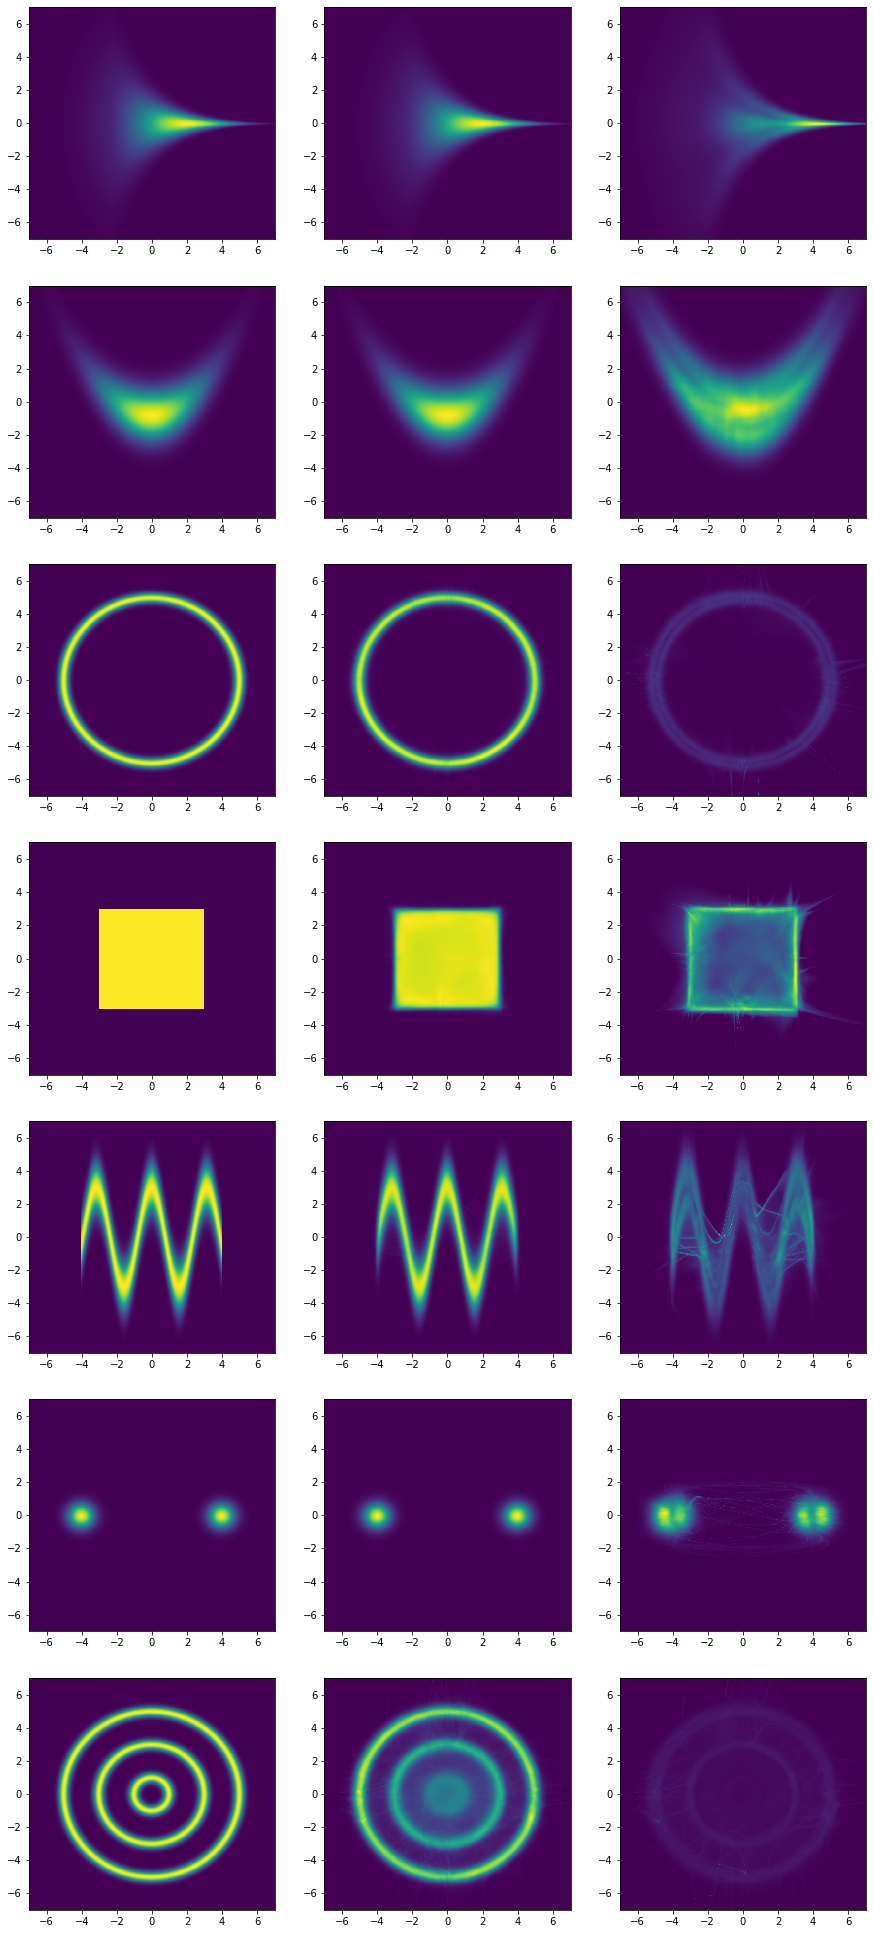

In [5]:
# plot mean and standard deviation
plt.figure(figsize=(15,35))
for i in range(len(names)):
    obj = objs[i]
    name = names[i]
    
    pX_ensemble = pX_dict[name]
    pX_mean = pX_ensemble.mean(axis=0)
    pX_std = pX_ensemble.std(axis=0)
    
    # clip large value
    #max_val = 0.1 * pX_std.max()
    #idx = pX_std > max_val
    #pX_std[idx] = max_val
    
    plt.subplot(7, 3, 3*i+1)
    plot_object2D(obj, x_interval, y_interval)
    plt.subplot(7, 3, 3*i+2)
    plt.pcolormesh(grid_x, grid_y, pX_mean, shading='auto')
    plt.subplot(7, 3, 3*i+3)
    plt.pcolormesh(grid_x, grid_y, pX_std, shading='auto')

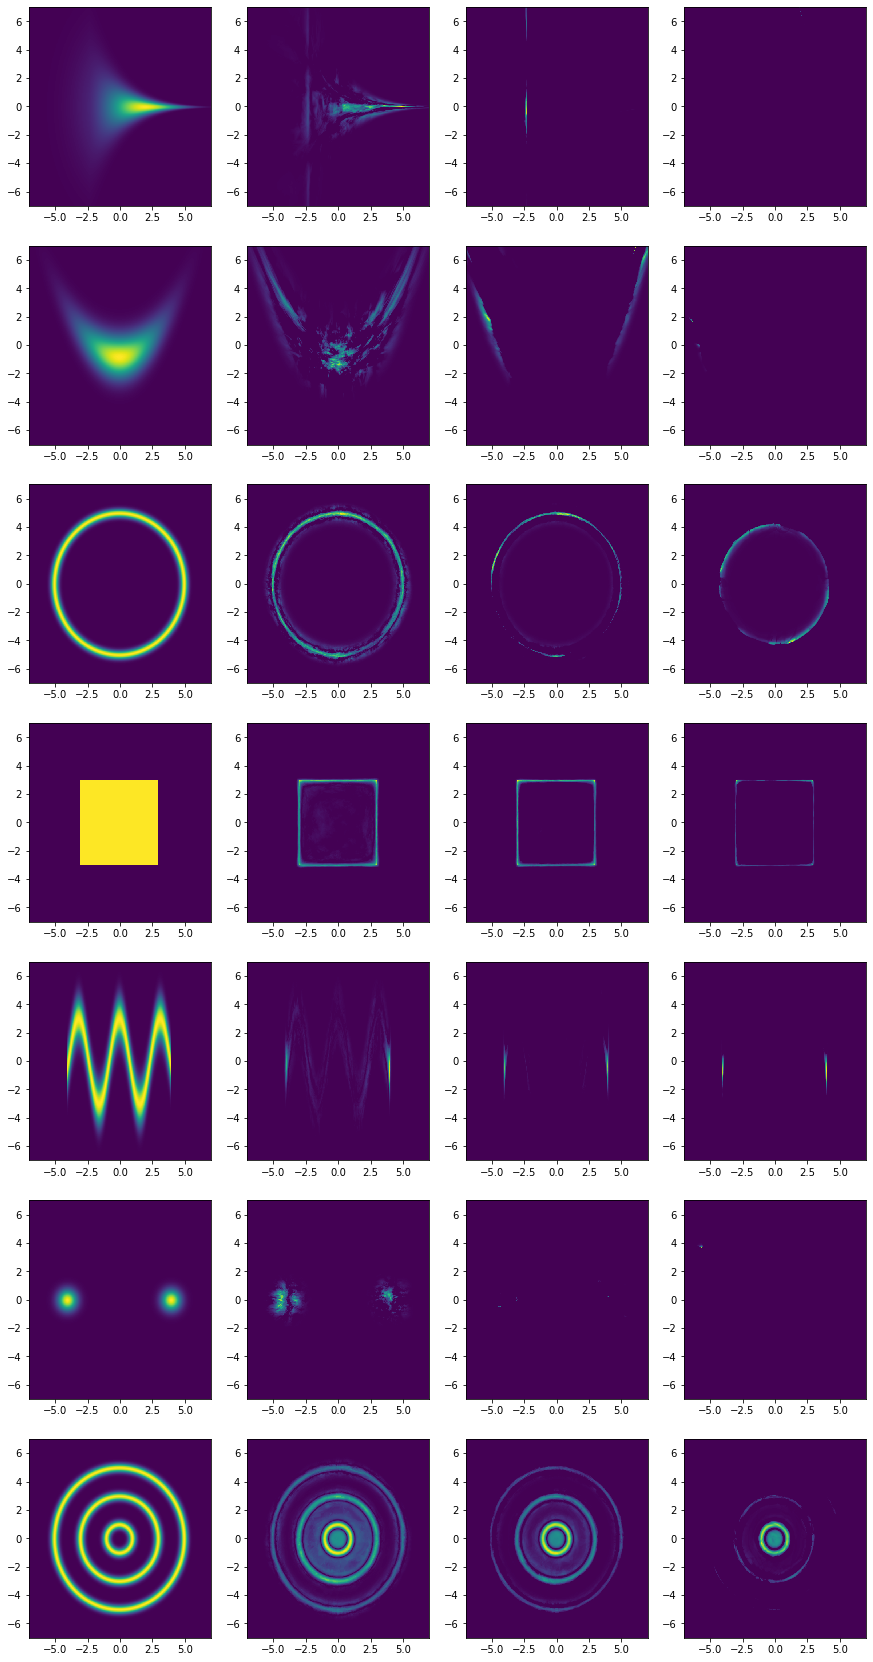

In [6]:
plt.figure(figsize=(15,30))
for i in range(len(names)):
    obj = objs[i]
    name = names[i]
    
    log_pX = obj.logpdf_multiple(X)
    pX = np.exp(log_pX).reshape(len(x_interval), len(y_interval))
    pX_ensemble = pX_dict[name]
    
    plt.subplot(7, 4, 4*i+1)
    plot_object2D(obj, x_interval, y_interval)
    plt.subplot(7, 4, 4*i+2)
    plot_outrange(pX, pX_ensemble, grid_x, grid_y, conf_interval=10)
    plt.subplot(7, 4, 4*i+3)
    plot_outrange(pX, pX_ensemble, grid_x, grid_y, conf_interval=50)
    plt.subplot(7, 4, 4*i+4)
    plot_outrange(pX, pX_ensemble, grid_x, grid_y, conf_interval=90)

In [16]:
conf_intervals = [10, 50, 90]

table = {}

for i in range(len(names)):
    obj = objs[i]
    name = names[i]
    
    log_pX = obj.logpdf_multiple(X)
    pX = np.exp(log_pX).reshape(len(x_interval), len(y_interval))
    pX_ensemble = pX_dict[name]
    
    means = []
    for conf_interval in conf_intervals:
        pX_outrange = np.zeros_like(pX)

        gap = (100 - conf_interval) / 2
        pX_down = np.percentile(pX_ensemble, gap, axis=0)
        pX_up = np.percentile(pX_ensemble, 100-gap, axis=0)

        idx_up = pX > pX_up
        idx_down = pX < pX_down

        pX_outrange[idx_up] = (pX - pX_up)[idx_up]
        pX_outrange[idx_down] = (pX_down - pX)[idx_down]

        means.append(pX_outrange.mean())
    print(name)
    
    table[name] = means
    

Funnel 0.00003
Funnel 0.00000
Funnel 0.00000
Banana 0.00002
Banana 0.00000
Banana 0.00000
Ring 0.00025
Ring 0.00003
Ring 0.00000
Uniform 0.00027
Uniform 0.00013
Uniform 0.00003
Cosine 0.00022
Cosine 0.00006
Cosine 0.00002
Grid 0.00010
Grid 0.00000
Grid 0.00000
Multiring 0.00175
Multiring 0.00085
Multiring 0.00023


In [105]:
print('\t\t', end='')
for conf_interval in conf_intervals:
    print(str(conf_interval) + '%', end='\t')

print('')

for name in names:
    print(name, end='    ')
    for mean in table[name]:
        print('\t%2.2f' % (mean*1e6), end='')
    
    print('')
    
print('\nAverage deviation from confidence interval * 1e6')

		10%	50%	90%	
Funnel    	30.00	0.31	0.00
Banana    	17.68	0.07	0.00
Ring    	250.76	32.64	0.39
Uniform    	267.82	129.84	25.62
Cosine    	221.31	60.95	24.10
Grid    	96.68	0.17	0.00
Multiring    	1746.12	854.11	226.90

Average deviation from confidence interval * 1e6
